In [1]:
import os
import cv2
import time
import random
import numpy as np
import zipfile

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import preprocess_input

import seaborn as sns
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
random.seed(3)
np.random.seed(3)
tf.random.set_seed(3)

ROOT = "/kaggle/input/"
KAGGLE_ROOT = '/kaggle/input/face-recognition-dataset/Extracted Faces/Extracted Faces'
INTERNET_ROOT = '/kaggle/input/indonesian-public-figure-faces/Extracted'
MODEL_ROOT = ROOT + '/model-siamese'

load_model = True
save_all = True
path = "training"
checkpoint_path = os.path.join(MODEL_ROOT, path)
checkpoint_dir = os.path.dirname(checkpoint_path)
epochs = 30

# Data ETL

In [4]:
# with zipfile.ZipFile(ROOT+'/kaggle/Kaggle_Dataset_Face_Recognition.zip', 'r') as zip_ref:
#     zip_ref.extractall(ROOT+'/kaggle')

In [5]:
def get_num_files(directory, folders):
    ret_map = {}

    for folder in folders:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        ret_map[folder] = num_files
  
    return ret_map

def split_dataset(directory, train_size=0.9):
    folders = os.listdir(directory)
    random.shuffle(folders)

    cut = int(len(folders) * train_size)

    train_map = get_num_files(directory, folders[:cut])
    test_map = get_num_files(directory, folders[cut:])

    return train_map, test_map

In [6]:
def create_triplets(directory, folder_list, max_files=10):
    triplets = []
    folders = list(folder_list.keys())
    
    for folder in folders:
        path = os.path.join(directory, folder)
        files = list(os.listdir(path))[:max_files]
        num_files = len(files)
        
        for i in range(num_files-1):
            for j in range(i+1, num_files):
                try:
                    anchor = (directory, folder, files[i])
                    positive = (directory, folder, files[j])

                    neg_folder = random.choice(folders)
                    while neg_folder == folder:
                        neg_folder = random.choice(folders)
                  
                    neg_file = random.choice(os.listdir(os.path.join(directory, neg_folder)))
                    negative = (directory, neg_folder, neg_file)

                    triplets.append((anchor, positive, negative))
                except:
                    pass
            
    random.shuffle(triplets)
    return triplets

In [7]:
def brightness(img, brightness):
    value = random.uniform(float(1/brightness), brightness)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv = np.array(hsv, dtype = np.float64)
    hsv[:,:,1] = hsv[:,:,1]*value
    hsv[:,:,1][hsv[:,:,1]>255]  = 255
    hsv[:,:,2] = hsv[:,:,2]*value 
    hsv[:,:,2][hsv[:,:,2]>255]  = 255
    hsv = np.array(hsv, dtype = np.uint8)
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return img

def horizontal_flip(img, flag):
    if flag == 1:
        return cv2.flip(img, 1)
    
    return img
  
def rotation(img, angle):
    angle = int(random.uniform(-angle, angle))
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
    img = cv2.warpAffine(img, M, (w, h))
    return img

def read_image(idx, brightness_val=2, hflip=True, rotation_val=20):
    path = os.path.join(idx[0], idx[1], idx[2])
    image = cv2.imread(path)
    image = cv2.resize(image, (224, 224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if(brightness_val != 1):
        image = brightness(image, brightness_val)
    if(hflip == True):
        image = horizontal_flip(image, random.randint(0, 1))
    if(rotation_val != 0):
        image = rotation(image, rotation_val)
    
    return image

In [8]:
def get_batch(triplet_list, batch_size=256, brightness_val=2, hflip=True, rotation_val=20):
    batch_steps = len(triplet_list)//batch_size
    
    for i in range(batch_steps+1):
        anchor   = []
        positive = []
        negative = []
        
        j = i*batch_size
        while j<(i+1)*batch_size and j<len(triplet_list):
            a, p, n = triplet_list[j]
            try:
                anchor.append(read_image(a, brightness_val=brightness_val, hflip=hflip, rotation_val=rotation_val))
                positive.append(read_image(p, brightness_val=brightness_val, hflip=hflip, rotation_val=rotation_val))
                negative.append(read_image(n, brightness_val=brightness_val, hflip=hflip, rotation_val=rotation_val))
            except:
                print(f"Error reading on {triplet_list[j]}")
                pass
            j+=1
            
        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)
        
        yield ([anchor, positive, negative])

### From Internet Source

In [9]:
train_list_internet, test_list_internet = split_dataset(INTERNET_ROOT, train_size=0.5)
print("Length of training list:", len(train_list_internet))
print("Length of testing list :", len(test_list_internet))

# train_list, test list contains the folder names along with the number of files in the folder.
print("\nTest List:", test_list_internet)

Length of training list: 49
Length of testing list : 50

Test List: {'Fatin_Shidqia': 8, 'Rossa': 7, 'Citra_Scholastika': 8, 'Pratama_Arhan': 7, 'Rizky_Febian': 6, 'Irfan_Jauhari': 5, 'Puan_Maharani': 6, 'Bintang_Emon': 6, 'Ebiet_G_Ade': 8, 'Bunga_Citra_Lestari': 7, 'Joko_Widodo': 9, 'Nike_Ardilla': 8, 'Inul_Daratista': 7, 'Mohammad_Ahsan': 5, 'Julia_Perez': 7, 'Arie_Kriting': 2, 'Sheryl_Sheinafia': 6, 'Aurel_Hermansyah': 4, 'Megawati_Soekarnoputri': 10, 'Rich_Brian': 5, 'Ria_Ricis': 4, 'Andovi_Da_Lopez': 7, 'Andhika_Pratama': 6, 'Bayu_Skak': 5, 'Basuki_Tjahaja_Purnama': 10, 'Lyodra_Ginting': 7, 'Yono_Bakrie': 5, 'Cinta_Laura': 8, 'Ahmad_Dhani': 6, 'Atta_Halilintar': 4, 'Ayu_Dewi': 8, 'Brian_Imanuel': 7, 'Naisa_Alifia_Yuriza': 7, 'Ernando_Ari': 8, 'Agnez_Mo': 9, 'Gilang_Dirga': 5, 'Maudy_Ayunda': 8, 'Anthony_Sinisuka_Ginting': 9, 'Yuni_Shara': 8, 'Windah_Basudara': 9, 'Alfeandra_Dewangga': 5, 'Tiara_Andini': 8, 'Susilo_Bambang_Yudhoyono': 7, 'Evie_Tamala': 6, 'Dewi_Lestari': 5, 'Gilang

In [10]:
train_triplet_internet = create_triplets(INTERNET_ROOT, train_list_internet)
test_triplet_internet  = create_triplets(INTERNET_ROOT, test_list_internet)

print("Number of training triplets:", len(train_triplet_internet))
print("Number of testing triplets :", len(test_triplet_internet))

print("\nExamples of triplets:")
for i in range(5):
    print(train_triplet_internet[i])

Number of training triplets: 931
Number of testing triplets : 1009

Examples of triplets:
(('/kaggle/input/indonesian-public-figure-faces/Extracted', 'Baim_Wong', '6.jpg'), ('/kaggle/input/indonesian-public-figure-faces/Extracted', 'Baim_Wong', '16.jpg'), ('/kaggle/input/indonesian-public-figure-faces/Extracted', 'Witan_Sulaeman', '19.jpg'))
(('/kaggle/input/indonesian-public-figure-faces/Extracted', 'Mamat_Alkatiri', '19.jpg'), ('/kaggle/input/indonesian-public-figure-faces/Extracted', 'Mamat_Alkatiri', '18.jpg'), ('/kaggle/input/indonesian-public-figure-faces/Extracted', 'Baim_Wong', '12.jpg'))
(('/kaggle/input/indonesian-public-figure-faces/Extracted', 'Witan_Sulaeman', '16.jpg'), ('/kaggle/input/indonesian-public-figure-faces/Extracted', 'Witan_Sulaeman', '17.jpg'), ('/kaggle/input/indonesian-public-figure-faces/Extracted', 'Glenn_Fredly', '20.jpg'))
(('/kaggle/input/indonesian-public-figure-faces/Extracted', 'Cak_Lontong', '20.jpg'), ('/kaggle/input/indonesian-public-figure-faces/

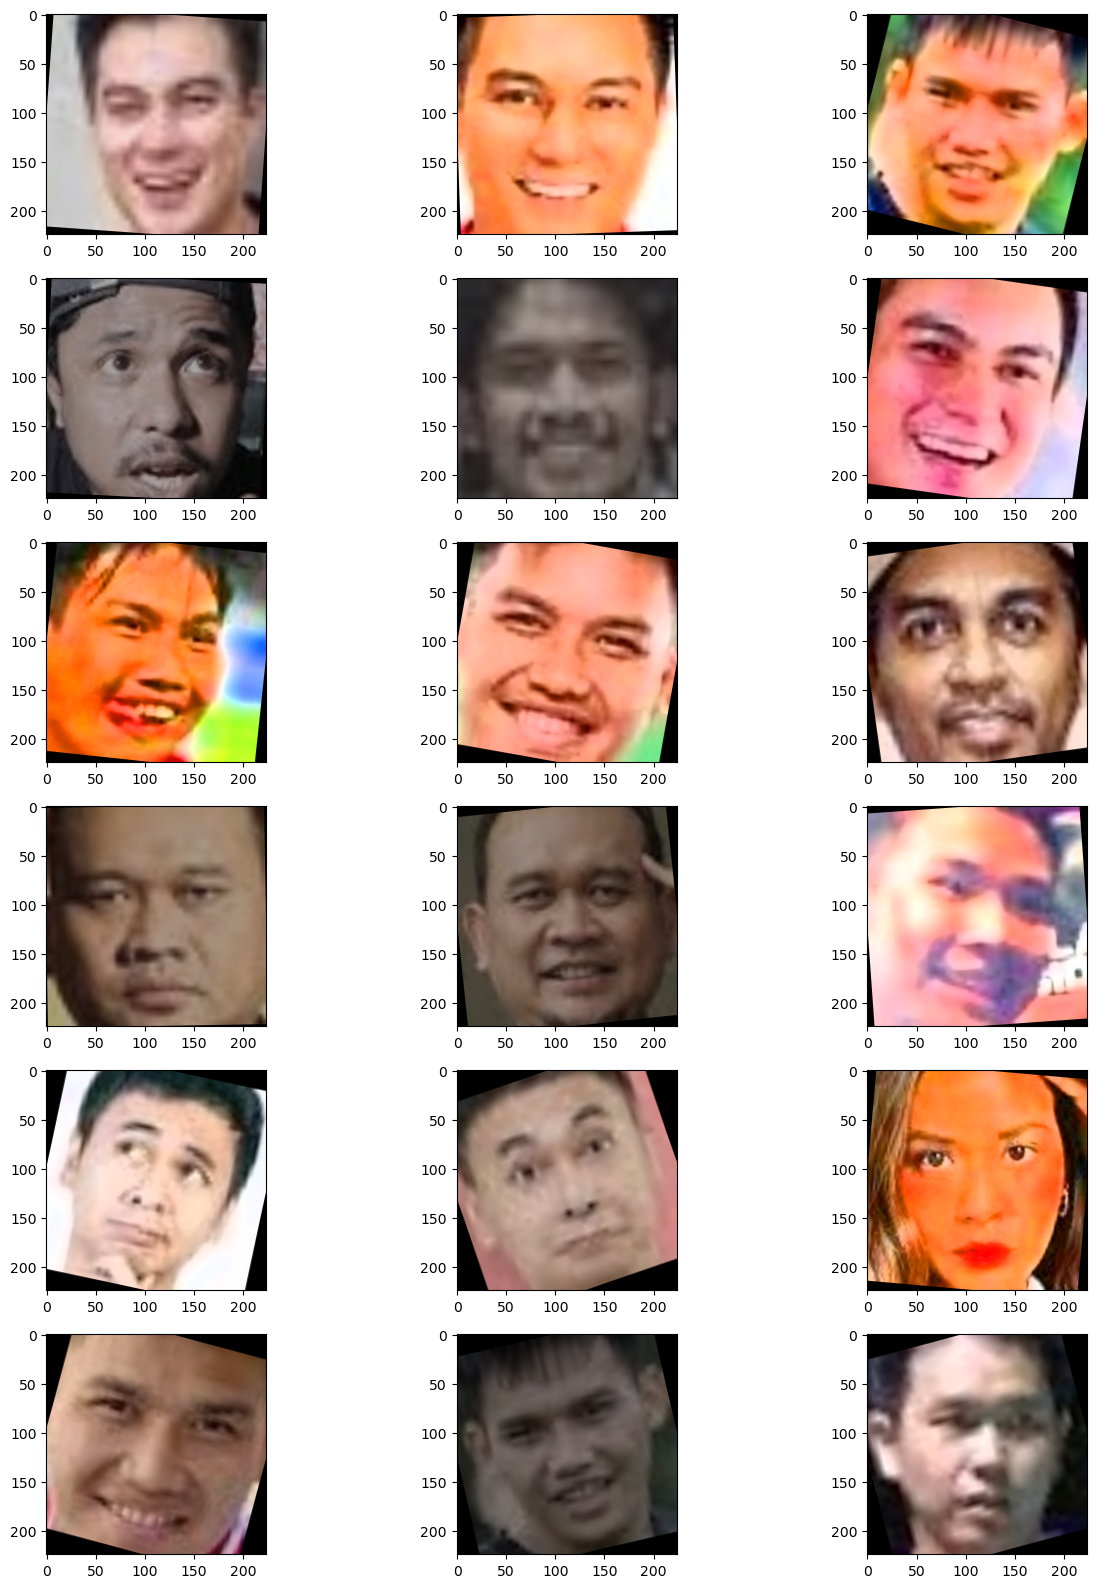

In [11]:
num_plots = 6

f, axes = plt.subplots(num_plots, 3, figsize=(15, 20))

for x in get_batch(train_triplet_internet, batch_size=num_plots):
    a,p,n = x
    for i in range(num_plots):
        axes[i, 0].imshow(a[i])
        axes[i, 1].imshow(p[i])
        axes[i, 2].imshow(n[i])
        i+=1
    break

In [12]:
# Joining train list
train_triplet = train_triplet_internet
test_triplet = test_triplet_internet

print("Number of training triplets:", len(train_triplet))
print("Number of testing triplets :", len(test_triplet))

print("\nExamples of triplets:")
for i in range(5):
    print(train_triplet[i])

Number of training triplets: 931
Number of testing triplets : 1009

Examples of triplets:
(('/kaggle/input/indonesian-public-figure-faces/Extracted', 'Baim_Wong', '6.jpg'), ('/kaggle/input/indonesian-public-figure-faces/Extracted', 'Baim_Wong', '16.jpg'), ('/kaggle/input/indonesian-public-figure-faces/Extracted', 'Witan_Sulaeman', '19.jpg'))
(('/kaggle/input/indonesian-public-figure-faces/Extracted', 'Mamat_Alkatiri', '19.jpg'), ('/kaggle/input/indonesian-public-figure-faces/Extracted', 'Mamat_Alkatiri', '18.jpg'), ('/kaggle/input/indonesian-public-figure-faces/Extracted', 'Baim_Wong', '12.jpg'))
(('/kaggle/input/indonesian-public-figure-faces/Extracted', 'Witan_Sulaeman', '16.jpg'), ('/kaggle/input/indonesian-public-figure-faces/Extracted', 'Witan_Sulaeman', '17.jpg'), ('/kaggle/input/indonesian-public-figure-faces/Extracted', 'Glenn_Fredly', '20.jpg'))
(('/kaggle/input/indonesian-public-figure-faces/Extracted', 'Cak_Lontong', '20.jpg'), ('/kaggle/input/indonesian-public-figure-faces/

# Model Building

In [13]:
import tensorflow as tf
from tensorflow.keras import backend, layers, metrics
from tensorflow.keras.layers import Input, Convolution2D, ZeroPadding2D,MaxPooling2D, Flatten, Dense, Dropout, Activation, Lambda

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [14]:
def build_vgg_face(input_shape=(224, 224, 3)):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=input_shape))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
#     model.add(Flatten())
#     model.add(Activation('softmax'))
    model.add(Flatten())
    model.add(Lambda(lambda x: tf.math.l2_normalize(x, axis=1)))
    
    return model

In [15]:
def build_encoder(input_shape):

#     pretrained_model = Xception(
#         input_shape=input_shape,
#         weights='imagenet',
#         include_top=False,
#         pooling='max',
#     )
    
#     for i in range(len(pretrained_model.layers)-27):
#         pretrained_model.layers[i].trainable = True

    pretrained_model = build_vgg_face(input_shape=input_shape)
    
    pretrained_model.load_weights('/kaggle/input/vggfaceweights/vgg_face_weights.h5')

#     model_encoder = Sequential([
#         pretrained_model,
        
#     ], name="Model_Encoder")

    return pretrained_model

In [16]:
class DistanceLayer(layers.Layer):
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        
        return (ap_distance, an_distance)

In [17]:
def build_siamese_network(input_shape = (224, 224, 3)):
    encoder = build_encoder(input_shape)
    
    # Input Layers for the images
    anchor_input   = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")
    
    # Generate the encodings (feature vectors) for the images
    encoded_a = encoder(anchor_input)
    encoded_p = encoder(positive_input)
    encoded_n = encoder(negative_input)
    
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    distances = DistanceLayer()(
        encoded_a,
        encoded_p,
        encoded_n
    )
    
    # Creating the Model
    siamese_network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )

    return siamese_network

In [18]:
siamese_network = build_siamese_network()
siamese_network.summary()

Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Anchor_Input (InputLayer)      [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Positive_Input (InputLayer)    [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Negative_Input (InputLayer)    [(None, 224, 224, 3  0           []                               
                                )]                                                  

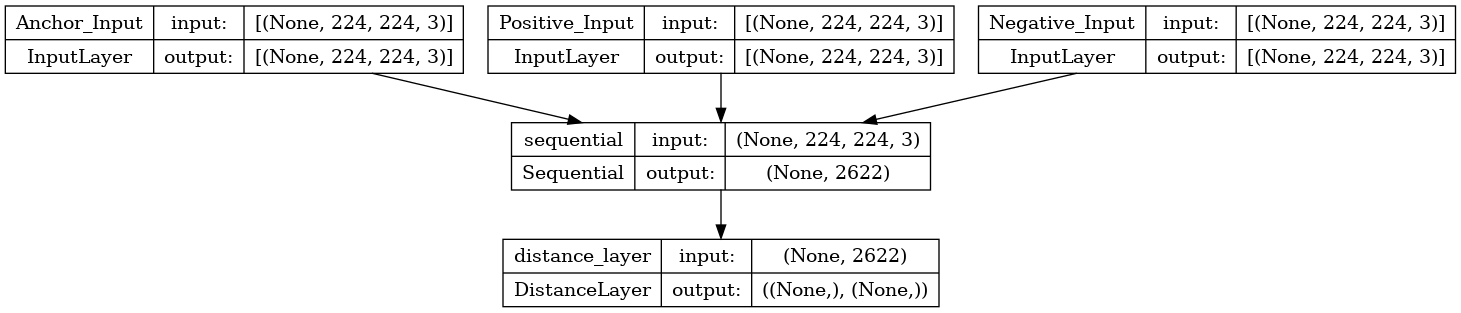

In [19]:
plot_model(siamese_network, show_shapes=True, show_layer_names=True)

In [20]:
class SiameseModel(Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=1.0):
        super(SiameseModel, self).__init__()
        
        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape get the gradients when we compute loss, and uses them to update the weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
            
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker]
        
    def save_weights(self, path):
      self.siamese_network.save_weights(path)

    def load_weights(self, path):
      self.siamese_network.load_weights(path)

In [21]:
siamese_model = SiameseModel(siamese_network)
if(load_model):
  try:
    siamese_model.load_weights(load_path)
  except:
    print("Failed to load model weigth, using default model")
    pass

optimizer = Adam(learning_rate=1e-3, epsilon=1e-01)
siamese_model.compile(optimizer=optimizer)

Failed to load model weigth, using default model


# Model Training

In [22]:
def test_on_triplets(batch_size = 256):
    pos_scores, neg_scores = [], []

    for data in get_batch(test_triplet, batch_size=batch_size, brightness_val=1, hflip=False, rotation_val=0):
        prediction = siamese_model.predict(data)
        pos_scores += list(prediction[0])
        neg_scores += list(prediction[1])
    
    accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    ap_mean = np.mean(pos_scores)
    an_mean = np.mean(neg_scores)
    ap_stds = np.std(pos_scores)
    an_stds = np.std(neg_scores)
    
    print(f"Accuracy on test = {accuracy:.5f}")
    return (accuracy, ap_mean, an_mean, ap_stds, an_stds)

In [23]:
batch_size = 10

max_acc = 0
train_loss = []
test_metrics = []

for epoch in range(1, epochs+1):
    # print(f"EPOCH {epoch}: ", end='')
    t = time.time()
    
    # Training the model on train data
    epoch_loss = []
    for data in get_batch(train_triplet, batch_size=batch_size):
        try:
            loss = siamese_model.train_on_batch(data)
            epoch_loss.append(loss)
        except Exception as e:
            print(e)
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    train_loss.append(epoch_loss)

    print(f"\nEPOCH: {epoch} \t (Epoch done in {int(time.time()-t)} sec)")
    print(f"Loss on train    = {epoch_loss:.5f}")
    
    # Testing the model on test data
    metric = test_on_triplets(batch_size=batch_size)
    test_metrics.append(metric)
    accuracy = metric[0]
    
    # Saving the model weights
    if save_all or accuracy>=max_acc:
        siamese_model.save_weights('siamese-network-{epoch:04d}.h5')
        max_acc = accuracy

# Saving the model after all epochs run
siamese_model.save_weights('siamese-network-final.h5')


EPOCH: 1 	 (Epoch done in 139 sec)
Loss on train    = 0.36779
1/1 [==============================] - 4s 4s/step
Accuracy on test = 0.85629

EPOCH: 2 	 (Epoch done in 113 sec)
Loss on train    = 0.25543
1/1 [==============================] - 0s 28ms/step
Accuracy on test = 0.82953

EPOCH: 3 	 (Epoch done in 114 sec)
Loss on train    = 0.28056
1/1 [==============================] - 0s 28ms/step
Accuracy on test = 0.80872

EPOCH: 4 	 (Epoch done in 114 sec)
Loss on train    = 0.34650
1/1 [==============================] - 0s 27ms/step
Accuracy on test = 0.72151

EPOCH: 5 	 (Epoch done in 114 sec)
Loss on train    = 0.41986
1/1 [==============================] - 0s 28ms/step
Accuracy on test = 0.73538

EPOCH: 6 	 (Epoch done in 114 sec)
Loss on train    = 0.45057
1/1 [==============================] - 0s 29ms/step
Accuracy on test = 0.77106

EPOCH: 7 	 (Epoch done in 114 sec)
Loss on train    = 0.34713
1/1 [==============================] - 0s 31ms/step
Accuracy on test = 0.69574

EPOCH: 

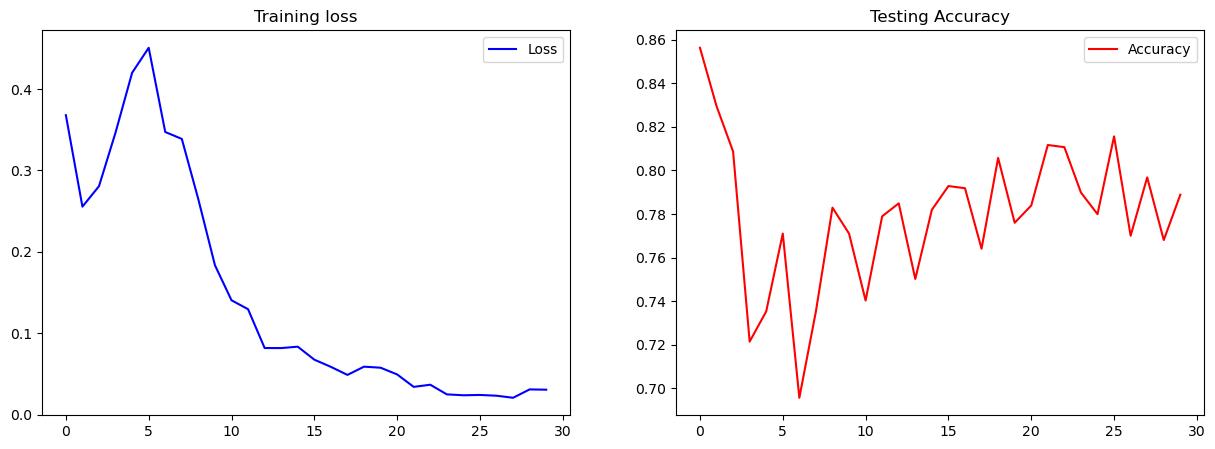

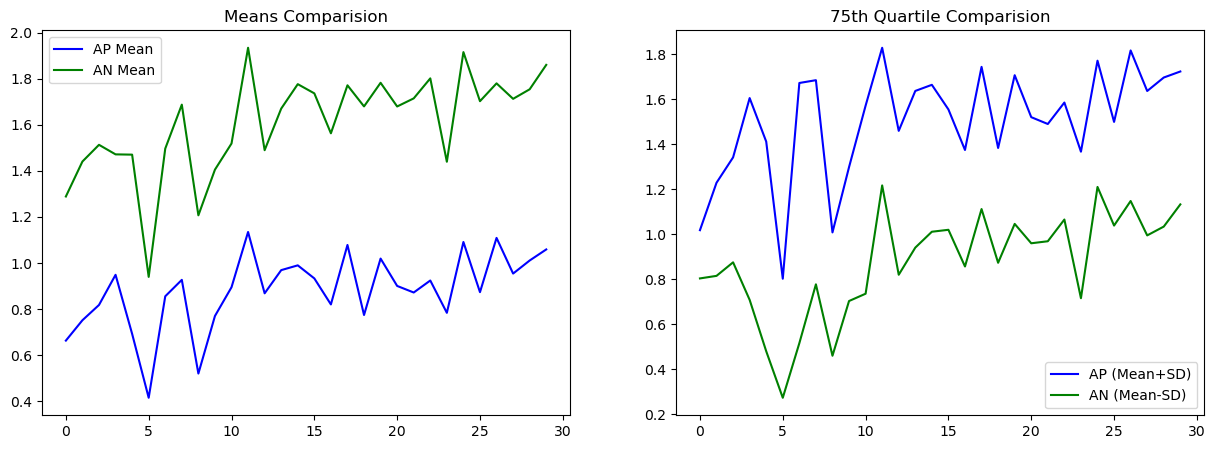

In [24]:
def plot_metrics(loss, metrics):
    # Extracting individual metrics from metrics
    accuracy = metrics[:, 0]
    ap_mean  = metrics[:, 1]
    an_mean  = metrics[:, 2]
    ap_stds  = metrics[:, 3]
    an_stds  = metrics[:, 4]
    
    plt.figure(figsize=(15,5))
    
    # Plotting the loss over epochs
    plt.subplot(121)
    plt.plot(loss, 'b', label='Loss')
    plt.title('Training loss')
    plt.legend()
    
    # Plotting the accuracy over epochs
    plt.subplot(122)
    plt.plot(accuracy, 'r', label='Accuracy')
    plt.title('Testing Accuracy')
    plt.legend()
    
    plt.figure(figsize=(15,5))
    
    # Comparing the Means over epochs
    plt.subplot(121)
    plt.plot(ap_mean, 'b', label='AP Mean')
    plt.plot(an_mean, 'g', label='AN Mean')
    plt.title('Means Comparision')
    plt.legend()
    
    # Plotting the accuracy
    ap_75quartile = (ap_mean+ap_stds)
    an_75quartile = (an_mean-an_stds)
    plt.subplot(122)
    plt.plot(ap_75quartile, 'b', label='AP (Mean+SD)')
    plt.plot(an_75quartile, 'g', label='AN (Mean-SD)')
    plt.title('75th Quartile Comparision')
    plt.legend()

test_metrics = np.array(test_metrics)
plot_metrics(train_loss, test_metrics)